TP- Recalage d'images
=============

In [52]:
import numpy as np
from scipy import signal
from scipy import interpolate
from PIL import Image
import matplotlib.pyplot as plt
import time

Un problème fréquemment rencontré dans le domaine du traitement d’images est celui du recalage. On dispose de plusieurs images prises à des temps différents, ou par des appareils différents, et on aimerait les mettre en correspondence, c’est-à-dire trouver une déformation du plan, qui assure une correspondence point à point des objets sous-jacents. Donnons quelques exemples d’applications :
* Traitements/retouches d’images. Par exemple, on peut vouloir construire un panoramique à partir d’images de petite taille. Il faut les recaler préalablement.
* Evaluation des déplacements d’objets dans des séquences vidéos (e.g. trouver un défaut de fonctionnement d’un organe, caméras de surveillance, design de robots intelligents ou de systèmes de navigation automatiques ...)
* Couplage d’informations. Par exemple, en imagerie médicale, on obtient une information plus riche en utilisant à la fois une radio et une angiographie. L’une apporte des informations structurelles, l’autre des informations fonctionnelles. Le couplage des deux images donne plus d’information au praticien.
* Beaucoup d’autres applications...

Dans ce TP, nous allons proposer un modèle de recalage assez élémentaire. Les idées constitutives se retrouvent cependant dans presque toutes les techniques récentes.

In [53]:
def get_images() :
    n=21
    sigma=0.3
    [X,Y]=np.meshgrid(np.linspace(-1,1,n),np.linspace(-1,1,n), indexing='xy')
    Z=np.sqrt(X*X+Y*Y)
    im1=np.zeros((n,n))
    im1[Z<=.7]=1.
    im1[Z<=.3]=.5
    im1[Z<=.1]=.7
    im2=np.zeros((n,n));
    Z=np.sqrt((X-.3)**2+(Y+.2)**2)
    im2[Z<=.7]=1
    im2[Z<=.3]=.5
    im2[Z<=.1]=.7
    G=np.fft.fftshift(np.exp(-(X**2+Y**2)/sigma**2))
    f=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im1)))
    g=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im2))) 
    f=f/np.max(f)
    g=g/np.max(g)
    return f,g,im1,im2

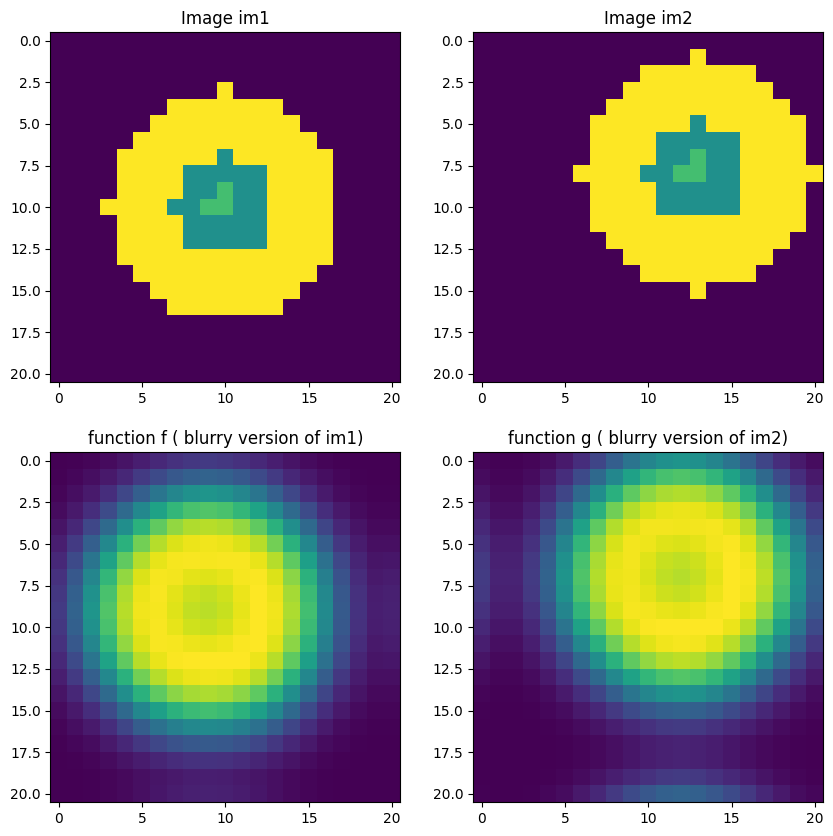

In [54]:
f,g,im1,im2=get_images()
fig, axarr = plt.subplots(2, 2, figsize=(10,10))
axarr[0,0].imshow(im1)
axarr[0,0].set_title('Image im1')
axarr[1,0].imshow(f)
axarr[1,0].set_title('function f ( blurry version of im1)')
axarr[0,1].imshow(im2)
axarr[0,1].set_title('Image im2')
axarr[1,1].imshow(g)
axarr[1,1].set_title('function g ( blurry version of im2)')
plt.show()

# 1. Formalisation du problème
## 1.1 Formalisme continu

On modélise les images en niveaux de gris comme des fonctions d’un ensemble borné $\Omega\subset \mathbb{R}$ (typiquement un carré) dans $\mathbb{R}$. La valeur de la fonction en chaque point représente l’intensité lumineuse de l’image. 

Soient $f$ et $g$ deux images. On a donc :
$$
f:\Omega\subset \mathbb{R}^2 \to \mathbb{R},  g:\Omega\subset \mathbb{R}^2 \to \mathbb{R} 
$$
En supposant que les images $f$ et $g$ dépendent seulement d’une transformation géométrique qui conserve la luminosité, le problème de recalage peut être formulé comme suit:

<div style="background-color:rgba(0, 0, 255, 0.1); padding:15px;margin:5px">
Problème $(P_1)$ : <br>
Etant donnés $f$ et $g$ dans $H_1(\Omega)$ (les images ont une amplitude bornée et une énergie finie), trouver un champ de vecteurs $u = (u_1, u_2) \in H_1(\Omega)^2$ tel que:
$$f(x + u(x)) = g(x), \forall x\in \Omega.$$
</div>

Le problème inverse est mal posé: tout d'abord, l'existence d'une solution n'est pas garantie, et dans le cas où il existe une solution, on n'a pas nécessairement unicité de cette solution. Par exemple, si $f$ et $g$ sont des fonctions constantes, n'importe quel déplacement $u$ est solution. Si $f$ est la constante $1$ et si $g$ est la constante $0$, il n'existe pas de solutions.

Pour le résoudre, on se propose de le reformuler comme un problème d'optimisation: 

<div style="background-color:rgba(0, 0, 255, 0.1); padding:15px;margin:5px">
Problème $(P_2)$ : <br>
On cherche une déformation $u$ du plan qui minimise:
$$
E(u)=\displaystyle\frac{1}{2}\int_\Omega (f(x+u(x))-g(x))^2 dx=\frac{1}{2}\|f\circ (id+u)-g\|^2.
$$
</div>

Sans hypothèse supplémentaire, le problème $\displaystyle \min_{u \in H^1(\Omega)^2} E(u)$ n'est a priori pas convexe, toujours mal posé et même éventuellement non différentiable si $u$ et $f$ ne sont pas assez régulières. On pourrait facilement rendre $f$ différentiable (en ajoutant du flou (on dit aussi du "bruit") par exemple à l'image, ce qui revient à convoler $f$ avec une gaussienne) mais il faut également "forcer" $u$ à être différentiable. Pour cela on propose de régulariser le problème de façon à assurer la convexité du problème d'optimisation considéré ainsi que l'existence et l'unicité des solutions.

Pour régulariser le problème inverse, nous allons faire une analogie avec l’élasticité linéaire. La fonction $u = (u_x,u_y)$ représente un champ de déformations. En notant $\partial x$ et $\partial y$ les opérateurs de dérivation partielle par rapport à chacun des axes du plan, on peut définir un potentiel élastique linéarisé :
$$
R(u)= \frac{\mu}{2}\int_{\Omega} \underbrace{ (\partial_x u_y + \partial_y u_x)^2(x,y) dxdy}_{R_1(u)=\textrm{cisaillement}} +\frac{\lambda+\mu}{2}\int_{\Omega} \underbrace{(\partial_x u_x + \partial_y u_y)^2(x,y) dxdy}_{R_2(u)=\textrm{variations  de  volume}}.
$$ 
En mécanique des structures, $\mu$ et $\lambda$ sont appelées constantes de Lamé. Le paramètre $\lambda$ n’a pas d’interprétation directe, tandis que le paramètre $\mu$ est appelé module de cisaillement.

Le problème d'optimisation à résoudre dans ce TP est le suivant:
<div style="background-color:rgba(0, 0, 255, 0.1); padding:15px;margin:5px">
    
$$(P)\qquad \min_{u} E(u)+R(u).$$
$$
E(u)=\displaystyle\frac{1}{2}\int_\Omega (f(x+u(x))-g(x))^2 dx=\frac{1}{2}\|f\circ (id+u)-g\|^2.
$$
$$
R(u)= \frac{\mu}{2}\int_{\Omega} \underbrace{ (\partial_x u_y + \partial_y u_x)^2(x,y) dxdy}_{R_1(u)=\textrm{cisaillement}} +\frac{\lambda+\mu}{2}\int_{\Omega} \underbrace{(\partial_x u_x + \partial_y u_y)^2(x,y) dxdy}_{R_2(u)=\textrm{variations  de  volume}}.
$$    
</div>

**Q1.** A l'aide d'un développement de Taylor, vérifier que le gradient de $E$ s'écrit:

$$\nabla E(u) = \left(f\circ (id+u) -g\right)\nabla f\circ (id+u)$$

au sens où la différentielle de $E$ est définie par:

$$dE(u)\cdot h= \displaystyle\int_\Omega \langle (f(x+u(x))-g(x))\nabla f(x+u(x)),h(x)\rangle dx.$$

Puis par définition, on a $$ dE(u)\cdot h =\langle \nabla E(u),h\rangle \quad \forall h$$
<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">
On a $\forall (u,h) \in (H_1(\Omega)^2)^2 : \\$
$$
\begin{align*}
E(u+h) 
&= \frac{1}{2}\int_{\Omega} \left[ f(x+u(x)+h(x)) - g(x)\right]^2 \, dx \\
&= \frac{1}{2} \int_{\Omega} \left[f(x+u(x)) + \langle \nabla f(x+u(x)), h(x) \rangle + o(\|h\|) - g(x) \right]^2 \, dx  &\text{car on suppose que } f \text{ est différentiable} \\
&= \frac{1}{2} \int_{\Omega} \left( \left[f(x+u(x)) - g(x)\right]^2 + 2 \langle \nabla f(x+u(x)), h(x) \rangle \left( f(x+u(x)) - g(x) \right) + o(\|h\|) \right) \, dx \\
&= E(u) + \int_{\Omega} \langle \left( f(x + u(x) - g(x) \right) \nabla f(x + u(x)), h(x) \rangle \, dx + o(\|h\|) \\
&= E(u) + dE(u)\cdot h + o(\|h\|) \\
&= E(u) + \langle \nabla E(u),h\rangle + o(\|h\|) \\
\end{align*}
$$

D'où $\nabla E(u) = \displaystyle\int_\Omega  (f(x+u(x))-g(x))\nabla f(x+u(x)) dx = \left(f\circ (id+u) -g\right)\nabla f\circ (id+u).$


</div>

# 2. Discrétisation

Pour pouvoir résoudre numériquement le problème $(P)$ (dont les variables de l'optimisation sont des fonctions !), on propose de le discrétiser au préalable. 

Soit $1\le i \le n$ and $1\le j\le m$. Notons $(x_i,y_j)$ le point de la grille $(i,j)$ et $f_{i,j}$ la valeur de $f$ au point $(x_i,y_j)$. Le produit scalaire sur $V=\mathcal M_{n,m}(\mathbb{R})$ est défini par:
$$\langle f,g\rangle_V=\sum_{i=1}^n\sum_{j=1}^m f_{i,j}g_{i,j},$$

## 2.1. Calcul du $E$ et de son gradient
Pour pouvoir calculer $E$ et son gradient, on va avoir besoin d'évaluer $f\circ (Id+u)$ et $\nabla f\circ(id+u)$. Pour cela, vous aurez besoin de la fonction `interpol` ci-dessous.

In [55]:
def interpol(function,ux,uy) :
    # function that computes f \circ Id+u and interpolates it on a mesh
    nx,ny=f.shape
    ip=interpolate.RectBivariateSpline(np.arange(nx),np.arange(ny),function)
    [X,Y]=np.meshgrid(np.arange(nx),np.arange(ny), indexing='ij')
    X=X+ux
    Y=Y+uy
    return np.reshape(ip.ev(X.ravel(),Y.ravel()),(nx,ny))

**Q2.** Lisez la documentation de la fonction `RectBivariateSpline` afin de comprendre ce que fait la fonction `interpol`.

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">
Le code effectue une interpolation bidimensionnelle d'une fonction sur une grille. La fonction prend en entrée un tableau bidimensionnel et deux paramètres de décalage ux et uy. La fonction (RectBivariateSpline) crée un objet d'interpolation. Ensuite, elle déplace les coordonnées de la grille en ajoutant les décalages ux et uy. Pour finir, les valeurs interpolées sont évaluées aux nouvelles coordonnées, les remodelant en un tableau 2D avec la forme initiale de la fonction.
En résumé, la fonction effectue une interpolation spatiale d'une fonction sur une grille, avec la possibilité de spécifier des décalages.
</div>


## 2.2. Calcul de $R$ et de son gradient
On discrétise également les opérateurs de dérivation partielles par différences finies ; par exemple la dérivée partielle par rapport à $x$ est donnée par, pour tout $f\in V$ par
$$\begin{cases}(\partial_x f)_{i,j}=f_{i+1,j}-f_{i,j} \text{ si } i<n \\
(\partial_x f)_{n,j}=0 \end{cases}.$$
On a ainsi $\partial_x f\in V$.

On définit les opérateurs $\partial_x^T$ et $\partial_y^T$ comme les uniques opérateurs qui vérifient

$$ \langle \partial_x^T f, g\rangle_V = \langle f,\partial_x  g\rangle_V \quad \forall f,g\in V$$
$$ \langle \partial_y^T f, g\rangle_V = \langle f,\partial_y  g\rangle_V \quad \forall f,g\in V$$

**Q2.** Donner les formules de discrétisation des opérateurs $\partial_y$, $\partial_x^\top$ et $\partial_y^\top$. Implémenter ces opérateurs ci-après. On donne un test de vérification.

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">
Pour $\partial _y$ : 
$$\begin{cases}(\partial_y f)_{i,j}=f_{i,j+1}-f_{i,j} \text{ si } j<n \\
(\partial_y f)_{i,n}=0 \end{cases} $$ 

Pour $\partial _x ^T$ : 
$$\begin{align}
\langle \partial _x u, v \rangle_V &= \sum_{i=1}^{n-1}\sum_{j=1}^{n}(u_{i+1,j}-u_{ij})v_{ij}\\
&=\sum_{i=1}^{n-1}\sum_{j=1}^{n}u_{i+1,j}v_{ij}-\sum_{i=1}^{n-1}\sum_{j=1}^{n}u_{ij}v_{ij}\\
&=\sum_{i=2}^{n}\sum_{j=1}^{n}u_{ij}v_{i-1,j}-\sum_{i=1}^{n-1}\sum_{j=1}^{n}u_{ij}v_{ij}\\
&=\sum_{i=2}^{n-1}\sum_{j=1}^{n}u_{ij}v_{i-1,j}-\sum_{i=2}^{n-1}\sum_{j=1}^{n}u_{ij}v_{ij} - \sum_{j=1}^{n} u_{1j}v_{1j} + \sum_{j=1}^{n} u_{nj}v_{n-1,j}\\
&=\sum_{i=2}^{n-1}\sum_{j=1}^{n}u_{ij}(v_{i-1,j}-v_{ij}) + \sum_{j=1}^{n} u_{nj}v_{n-1,j}-u_{1j}v_{1j}\\ \\ \\
\end{align}$$

Par identification :
$$\partial _x ^T=\begin{cases}f_{i-1,j}-f_{ij} \text{ si } i\in[2;n-1] \\
        f_{n-1,j} \text{ si } i=n \\
        -f_{1j} \text{ si } i=1 \end{cases} $$

Pour $\partial _y ^T$ : 
$$\begin{align}
\langle \partial _y u, v \rangle_V &= \sum_{i=1}^{n}\sum_{j=1}^{n-1}(u_{i,j+1}-u_{ij})v_{ij}\\
&=\sum_{i=1}^{n}\sum_{j=1}^{n-1}u_{i,j+1}v_{ij}-\sum_{i=1}^{n}\sum_{j=1}^{n-1}u_{ij}v_{ij}\\
&=\sum_{i=1}^{n}\sum_{j=2}^{n}u_{ij}v_{i,j-1}-\sum_{i=1}^{n}\sum_{j=1}^{n-1}u_{ij}v_{ij}\\
&=\sum_{i=1}^{n}\sum_{j=2}^{n-1}u_{ij}v_{i,j-1}-\sum_{i=1}^{n}\sum_{j=2}^{n-1}u_{ij}v_{ij} - \sum_{i=1}^{n} u_{i1}v_{i1} + \sum_{i=1}^{n} u_{in}v_{i,n-1}\\
&=\sum_{i=1}^{n}\sum_{j=2}^{n-1}u_{ij}(v_{i,j-1}-v_{ij}) + \sum_{i=1}^{n} u_{in}v_{i,n-1}-u_{i1}v_{i1}\\ \\ \\
\end{align}$$

Par identification:
$$\partial _y ^T=\begin{cases}f_{i,j-1}-f_{ij} \text{ si } j\in[2;n-1] \\
        f_{i,n-1} \text{ si } j=n \\
        -f_{i1} \text{ si } j=1 \end{cases} $$

</div>


In [56]:
def dx(im) :
    d=np.zeros(im.shape)
    d[:-1,:]=im[1:,:]-im[:-1,:]
    return d
def dy(im) :
    d=np.zeros(im.shape)
    d[:,:-1]=im[:,1:]-im[:,:-1]
    return d
def dyT(im) :
    d=np.zeros(im.shape)
    d[:,0]=-im[:,0]
    d[:,-1]=im[:,-2]
    d[:,1:-1]=im[:,0:-2]-im[:,1:-1]  
    return d  
def dxT(im) :
    d=np.zeros(im.shape)
    d[0,:]=-im[0,:]
    d[-1,:]=im[-2,:]
    d[1:-1,:]=im[0:-2,:]-im[1:-1,:]   
    return d

def scal(a,b) :
    assert a.shape==b.shape
    return np.sum(a*b)

np.random.seed(42)
im1=np.random.randn(12,15)
im2=np.random.randn(12,15)
print(scal(dx(im1),im2),'=',scal(im1,dxT(im2)))

-17.489408391382973 = -17.489408391382973


**Q3.**  On peut alors écrire :
$$
R(u)= \frac{\mu}{2}\underbrace{\sum_{i}(\partial_x u_y + \partial_y u_x)^2(i)}_{=R_1(u)} + \frac{\lambda+\mu}{2} \underbrace{\sum_i(\partial_x u_x + \partial_y u_y)^2(i)}_{=R_2(u)}.
$$ 
où:
* $u_x\in V$ et $u_y\in V$ sont les discrétisations des composantes du champ de vecteurs $u$ sur la grille choisie
* $\partial_x:V \rightarrow V$ et $\partial_y:V\rightarrow V$ représentent les opérateurs de différences finies.

On peut ré-écrire $R(u)=\frac{\mu}{2}R_1(u)+ \frac{\lambda+\mu}{2} R_2(u)$ avec : 
$$
R_1(u)=\langle A_1 u , A_1 u\rangle_V,\qquad R_2(u)=\langle A_2 u , A_2 u\rangle_V.
$$
Où $A_i$ est un opérateur de $V^2$ dans $V$.
Donnez l'expression des matrices $A_1$ et $A_2$ en fonction des opérateurs $\partial_x$ et $\partial_y$.


<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">
Pour $A_1$ : 
$$R_1(u) = \langle A_1 u , A_1 u\rangle_V = \|A_1u\|^2_V = \|A_1 \begin{bmatrix}
  u_x\\
u_y
\end{bmatrix}\|^2_V =  \|\partial_x u_y + \partial_y u_x \|^2_V = \|
\begin{bmatrix}
    dy \\
    dx
\end{bmatrix}^T \begin{bmatrix}
  u_x\\
u_y
\end{bmatrix}
 \
 \|^2_V$$ 
D'où, $$A_1 = \begin{bmatrix}
    dy &  dx
\end{bmatrix}$$

Pour $A_2$ : 
$$R_2(u) = \langle A_2 u , A_2 u\rangle_V = \|A_2u\|^2_V = \|A_2 \begin{bmatrix}
  u_x\\
u_y
\end{bmatrix}\|^2_V =  \|\partial_x u_x + \partial_y u_y \|^2_V = \|
\begin{bmatrix}
    dx \\
    dy
\end{bmatrix}^T \begin{bmatrix}
  u_x\\
u_y
\end{bmatrix}
 \
 \|^2_V$$ 
D'où, $$A_2 = \begin{bmatrix}
    dx &  dy
\end{bmatrix}$$
</div>


**Q3b.**
Pour tout $u=(u_x,u_y)$ et $v=(v_x,v_y)$ dans $V^2$, on définit le produit scalaire dans $V^2$ par
$$\langle u,v\rangle_{V^2}=\langle u_x,v_x\rangle_{V}+\langle u_y,v_y\rangle_{V}$$

Montrer que $R(u)$ peut s'écrire sous la forme:
$$R(u)=\frac{1}{2} \langle A\left(\begin{array}{c}
u_x\\
u_y
\end{array}\right),\left(\begin{array}{c}
u_x\\
u_y
\end{array}\right)\rangle_{V^2},$$

Avec $$A=\mu A_1^TA_1 +(\lambda+\mu) A_2^TA_2$$ et $A_i^T$ un opérateur de $V^2$ dans $V$.

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">
\[
\begin{align*}
R(u) &= \frac{\mu}{2}\langle A_1 u, A_1 u\rangle_{V^2} + \frac{\lambda + \mu}{2}\langle A_2 u, A_2 u\rangle_{V^2} \\
&= \frac{\mu}{2}\left(\langle \begin{bmatrix} dy & dx \end{bmatrix}^T \begin{bmatrix} u_x \\ u_y \end{bmatrix}, \begin{bmatrix} dy & dx \end{bmatrix}^T \begin{bmatrix} u_x \\ u_y \end{bmatrix} \rangle_{V} \right) \\
&\quad+ \frac{\lambda + \mu}{2}\left(\langle \begin{bmatrix} dx & dy \end{bmatrix}^T \begin{bmatrix} u_x \\ u_y \end{bmatrix}, \begin{bmatrix} dx & dy \end{bmatrix}^T \begin{bmatrix} u_x \\ u_y \end{bmatrix} \rangle_{V} \right) \\
&= \frac{1}{2}\left(\mu \langle \begin{bmatrix} dy & dx \end{bmatrix}^T \begin{bmatrix} u_x \\ u_y \end{bmatrix}, \begin{bmatrix} dy & dx \end{bmatrix}^T \begin{bmatrix} u_x \\ u_y \end{bmatrix} \rangle_{V} \right) \\
&\quad+ \frac{1}{2}\left((\lambda + \mu) \langle \begin{bmatrix} dx & dy \end{bmatrix}^T \begin{bmatrix} u_x \\ u_y \end{bmatrix}, \begin{bmatrix} dx & dy \end{bmatrix}^T \begin{bmatrix} u_x \\ u_y \end{bmatrix} \rangle_{V} \right) \\
&= \frac{1}{2}\left(\langle \mu \begin{bmatrix} dy & dx \end{bmatrix}^T \begin{bmatrix} u_x \\ u_y \end{bmatrix} + (\lambda + \mu) \begin{bmatrix} dx & dy \end{bmatrix}^T \begin{bmatrix} u_x \\ u_y \end{bmatrix}, \mu \begin{bmatrix} dy & dx \end{bmatrix}^T \begin{bmatrix} u_x \\ u_y \end{bmatrix} + (\lambda + \mu) \begin{bmatrix} dx & dy \end{bmatrix}^T \begin{bmatrix} u_x \\ u_y \end{bmatrix} \rangle_{V} \right) \\
&= \frac{1}{2}\left(\langle \mu A_1^TA_1 \begin{bmatrix} u_x \\ u_y \end{bmatrix} + (\lambda + \mu) A_2^TA_2 \begin{bmatrix} u_x \\ u_y \end{bmatrix}, \begin{bmatrix} u_x \\ u_y \end{bmatrix} \rangle_{V} \right) \\
&= \frac{1}{2}\langle A\begin{bmatrix} u_x \\ u_y \end{bmatrix}, \begin{bmatrix} u_x \\ u_y \end{bmatrix} \rangle_{V^2},
\end{align*}
\]

où $$A = \mu A_1^TA_1 + (\lambda + \mu) A_2^TA_2$$

</div>

**Q4.** Donner l'expression du gradient de $R$.
<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">
Comme $R(u)=\frac{\mu}{2}R_1(u)+ \frac{\lambda+\mu}{2} R_2(u)$, on a $\nabla R(u) = \frac{\mu}{2} \nabla R_1(u) + \frac{\lambda+\mu}{2} \nabla R_2(u)$. 

Pour $\nabla R_1(u)$ : 

On a $\forall (u,h) \in V^2$ :
$$
\begin{align*}
R_1(u+h) 
&= R_1(u) + 2 \langle A_1^T A_1 u,h\rangle + o(\|h\|) \\
\end{align*}
$$
Ainsi : 

$$
\begin{align}
\nabla R_1(u) &= 2 A_1^T A_1 u \\
&= 2 \begin{bmatrix}
\partial_y^T \\
\partial_x^T
\end{bmatrix} \begin{bmatrix}
\partial_y & \partial_x
\end{bmatrix} \begin{bmatrix}
u_x \\
u_y
\end{bmatrix} \\
&= 2 \begin{bmatrix}
\partial_y^T \partial_y & \partial_y^T \partial_x \\
\partial_x^T \partial_y & \partial_x^T \partial_x
\end{bmatrix} \begin{bmatrix}
u_x \\
u_y
\end{bmatrix} \\
&= 2 \begin{bmatrix}
\partial_y^T \partial_y u_x + \partial_y^T \partial_x u_y \\
\partial_x^T \partial_y u_x + \partial_x^T \partial_x u_y
\end{bmatrix}
\end{align}
$$

Pour $\nabla R_2(u)$ : 

On a $\forall (u,h) \in V^2$ :
$$
\begin{align*}
R_2(u+h) 
&= R_2(u) + 2 \langle A_2^T A_2 u,h\rangle + o(\|h\|) \\
\end{align*}
$$
Ainsi : 
$$\begin{align}
\nabla R_2(u) &= 2 A_2^T A_2 u \\
&= 2 \begin{bmatrix}
\partial_x^T\\
\partial_y^T
\end{bmatrix} (\partial_x \text{ } \partial_y) \begin{bmatrix}
u_x\\
u_y
\end{bmatrix} \\
&= 2 \begin{bmatrix}\partial_x^T\partial_x & \partial_x^T\partial_y \\ \partial_y^T\partial_x & \partial_y^T\partial_y \end{bmatrix} \begin{bmatrix}
u_x\\
u_y
\end{bmatrix} \\
&= 2 \begin{bmatrix}\partial_x^T\partial_x u_x + \partial_x^T\partial_y u_y\\ \partial_y^T\partial_x u_x +  \partial_y^T\partial_y u_y\end{bmatrix}
\end{align}$$

Finalement, on a : 
$$ \nabla R(u) = \mu \begin{bmatrix}\partial_y^T\partial_yu_x + \partial_y^T\partial_xu_y\\ \partial_x^T\partial_yu_x +  \partial_x^T\partial_xu_y\end{bmatrix} + (\lambda +\mu) \begin{bmatrix}\partial_x^T\partial_x u_x + \partial_x^T\partial_y u_y\\ \partial_y^T\partial_x u_x +  \partial_y^T\partial_y u_y\end{bmatrix}
$$
</div>

## 2.3. Implémentation de la fonction objectif $E+R$

Créez une fonction `objective_function` qui calcul $E(u)+R(u)$. 

Cette fonction prend en variable d'entrée 
* `f`,`g` et `ux` et `uy` qui sont nécessaires au calcul de $E(u)$
* `ux`,`uy` ,`lamb` et `mu` qui sont nécessaires au calcul de $R(u)$. Ici `lamb` et `mu` sont deux variables réelles positives qui représentent $\lambda$ et $\mu$. 


Cette fonction doit rendre deux arguments :
* `obj` qui est la valeur de $E(u)+R(u)$
* `fu` qui est un tableau qui représente le résultat du calcul de $f\circ(Id +u)$. On rend ce tableau car il sera utile pour les prochains calculs.

In [57]:
def objective_function(f,g,ux,uy,lamb,mu) :
    #implementation de E(u)+R(u)
    fu=interpol(f, ux, uy)
    
    #Calcul de R
    R= mu/2 * np.linalg.norm(dx(uy)+dy(ux))**2 + (lamb+mu)/2 * np.linalg.norm(dx(ux)+dy(uy))**2
    
    #Calcul de E
    E=1/2*np.linalg.norm(fu-g)**2  
    
    obj = R+E
    return obj,fu

np.random.seed(12)
ux=np.random.randn(f.shape[0],f.shape[1])
uy=np.random.randn(f.shape[0],f.shape[1])
obj,fu=objective_function(2*f,3*g,ux,uy,10,5)
print(obj,fu.shape,np.linalg.norm(fu)) #18215.406074781582 (21, 21) 22.047265562734097

18215.406074781582 (21, 21) 22.047265562734097


## 2.4 Implémentation des gradients
Créez une fonction `gradE` et `gradR` qui calcule $\nabla E(u)$ et $\nabla R(u)$. On garde les conventions de noms de variable de la section précédente et on notera `gradxE,gradyE` les deux composantes de  $\nabla E(u)$ et `gradxR,gradyR` les deux composantes de $\nabla R(u)$. Les variables `dfx` et `dfy`contiennent les dérivées selon `x` et `y` de `f`, elles seront initalisées par `dfx=dx(f)` et `dfy=dy(f)`

In [58]:
def gradE(dfx,dfy,g,fu,ux,uy) :
    gradxE=(fu-g)*(interpol(dfx,ux,uy))
    gradyE=(fu-g)*(interpol(dfy,ux,uy))
    return gradxE,gradyE

def gradR(lamb,mu,ux,uy) :
    gradxR = mu*dyT(dy(ux)) + (lamb+mu)*dxT(dx(ux)) + mu*dyT(dx(uy)) + (lamb+mu)*dxT(dy(uy))
    gradyR = mu*dxT(dy(ux)) + (mu+lamb)*dyT(dx(ux)) + mu*dxT(dx(uy)) + (lamb+mu)*dyT(dy(uy))
    return gradxR,gradyR

In [59]:
dfx=dx(f)
dfy=dy(f)  
np.random.seed(12)
ux=np.random.randn(f.shape[0],f.shape[1])
uy=np.random.randn(f.shape[0],f.shape[1])
obj,fu=objective_function(f,g,ux,uy,10,5)
gradxE,gradyE=gradE(dfx,dfy,g,fu,ux,uy)
print(gradxE.shape,gradyE.shape) #(21, 21) (21, 21)
print(np.linalg.norm(gradxE),np.linalg.norm(gradyE)) #0.6513993385167333 0.6040320505869908
gradxR,gradyR=gradR(10.,5.,ux,uy) 
print(gradxR.shape,gradyR.shape)  #(21, 21) (21, 21)
print(np.linalg.norm(gradxR),np.linalg.norm(gradyR)) #1180.7792368512296 1239.1880693357143

(21, 21) (21, 21)
0.6513993385167333 0.6040320505869909
(21, 21) (21, 21)
1180.7792368512296 1239.1880693357143


# 3. Un algorithme de gradient

Une itération de la méthode de descente de gradient est de la forme:

$$
u_{k+1}=u_k-s_k(\nabla E(u) + \nabla R(u))
$$

**Q5.** Compléter la fonction RecalageDG implémentant la descente de gradient et utilisant l'algorithme de recherche linéaire par rebroussement proposé ci-dessous.

In [60]:
def linesearch(ux,uy,step,descentx,descenty,obj_old,f,g,lamb,mu) :
    step=2*step
    tmpx=ux-step*descentx
    tmpy=uy-step*descenty
    obj,fu=objective_function(f,g,tmpx,tmpy,lamb,mu)
    while obj >obj_old and step > 1.e-8:
        step=0.5*step
        tmpx=ux-step*descentx
        tmpy=uy-step*descenty
        obj,fu=objective_function(f,g,tmpx,tmpy,lamb,mu)
    return tmpx,tmpy,step


def RecalageDG(f,g,lamb,mu,nitermax,stepini) : 
    ux=np.zeros(f.shape)
    uy=np.zeros(f.shape)  
    CF=[]
    step_list=[]
    niter=0
    step=stepini
    dfx = dx(f)
    dfy = dy(f)
    # raise ValueError('Compute dfx and dfy here')
    while niter < nitermax and step > 1.e-8 : 
        niter+=1
        obj,fu=objective_function(f,g,ux,uy,lamb,mu)
        CF.append(obj) 
        gradiE = gradE(dfx,dfy,g,fu,ux,uy)
        gradiR = gradR(lamb,mu,ux,uy)
        # raise ValueError('Compute gradxE and gradyE here')
        # raise ValueError('Compute gradRx and gradRy here')
        # raise ValueError('Compute gradx and grady here')

        gradx = gradiE[0] + gradiR[0]
        grady = gradiE[1] + gradiR[1]
        
        ux,uy,step=linesearch(ux,uy,step,gradx,grady,obj,f,g,lamb,mu)
        step_list.append(step)
        if (niter % 3 ==0) :
            print('iteration :',niter,' cost function :',obj,'step :',step, 'lambda :', lamb, 'mu :', mu)
    return ux,uy,np.array(CF),np.array(step_list), niter

**Q5.** Ecrire un compte-rendu des expériences réalisées et des résultats obtenus. Commentez.

In [16]:
lamb=10
mu=20
nitermax=500
step0 = 0.01
start_time = time.time()
ux,uy,CF,step, niter=RecalageDG(f,g,lamb,mu,nitermax,step0)
print("Execution time: %s seconds" % (time.time() - start_time))
# la premiere ligne est 
# iteration : 3  cost function : 19.08125492560699 step : 0.08

iteration : 3  cost function : 19.08125492560699 step : 0.08 lambda : 10 mu : 20
iteration : 6  cost function : 19.04274372706119 step : 0.02 lambda : 10 mu : 20
iteration : 9  cost function : 19.031367910404175 step : 0.01 lambda : 10 mu : 20
iteration : 12  cost function : 19.02412383888724 step : 0.01 lambda : 10 mu : 20
iteration : 15  cost function : 19.01806210880887 step : 0.01 lambda : 10 mu : 20
iteration : 18  cost function : 19.01253459257596 step : 0.005 lambda : 10 mu : 20
iteration : 21  cost function : 19.008553844127363 step : 0.005 lambda : 10 mu : 20
iteration : 24  cost function : 19.003094849027036 step : 0.005 lambda : 10 mu : 20
iteration : 27  cost function : 18.998331455413695 step : 0.005 lambda : 10 mu : 20
iteration : 30  cost function : 18.993817208909224 step : 0.005 lambda : 10 mu : 20
iteration : 33  cost function : 18.98942613970379 step : 0.005 lambda : 10 mu : 20
iteration : 36  cost function : 18.985108875837884 step : 0.01 lambda : 10 mu : 20
iterati

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">
Pour trouver les lambda et mu optimaux, nous allons essayer différentes valeurs avec le code ci-dessous. Puis nous allons choisir les valeurs correspondant à un nombre d'itérations minimal et ayant une fonction coût de petite valeur. <br> <br>

Nous commençons par encadrer "grossièrement" les valeurs de lambda et mu, puis nous précisons nos encadrements en fonction des résultats. Dans l'exemple ci dessous nous supposons lambda et mu entre 0 et 0.2.
</div>

In [72]:
# niter0_ex = np.zeros((5,5))
# lamb_ex = np.linspace(0,0.1,5)
# mu_ex = np.linspace(0,0.1,5)
# step0 = 0.01

# for i in range(5) :
#     for j in range(5) :
#         start_time = time.time()
#         ux,uy,CF,step,niter0_ex[i,j] = RecalageDG(f,g,lamb_ex[i],mu_ex[j],5000,step0)
#         print("Execution time: %s seconds" % (time.time() - start_time))   

In [73]:
# niter0_ex

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">
Si on run les cellules ci-dessus, nous pouvons voir que le nombre d'itérations minimale (515) est obtenu pour lambda = 0.025 et mu = 0.0.
<br> <br>
En continuant avec ce raisonnement, nous choisissons finalement les valeurs suivantes :
<li><b>lambda = 0.011</b></li>
<li><b>mu = 0.009</b></li>
Pour un nombre d'itérations de <b>519</b> et une fonction coût ayant une valeur d'environ <b>0.30</b>. <br> <br>

On notera qu'on pouvait avoir un nombre d'itération plus petit mais on aurait perdu en précision.
</div>

In [71]:
lamb=0.011
mu=0.009
nitermax=1000
step0 = 0.01
start_time = time.time()
ux,uy,CF,step,niter =RecalageDG(f,g,lamb,mu,nitermax,step0)
print("Execution time: %s seconds" % (time.time() - start_time))


iteration : 3  cost function : 19.06625363244492 step : 0.08 lambda : 0.011 mu : 0.009
iteration : 6  cost function : 18.597036321022046 step : 0.64 lambda : 0.011 mu : 0.009
iteration : 9  cost function : 15.232498809913661 step : 5.12 lambda : 0.011 mu : 0.009
iteration : 12  cost function : 5.219697550752853 step : 40.96 lambda : 0.011 mu : 0.009
iteration : 15  cost function : 2.9515882398510183 step : 10.24 lambda : 0.011 mu : 0.009
iteration : 18  cost function : 2.2646798244493302 step : 10.24 lambda : 0.011 mu : 0.009
iteration : 21  cost function : 2.0174315307883144 step : 5.12 lambda : 0.011 mu : 0.009
iteration : 24  cost function : 1.7145395496569165 step : 10.24 lambda : 0.011 mu : 0.009
iteration : 27  cost function : 1.4976820439467233 step : 10.24 lambda : 0.011 mu : 0.009
iteration : 30  cost function : 1.3387415820320179 step : 10.24 lambda : 0.011 mu : 0.009
iteration : 33  cost function : 1.220218620088152 step : 10.24 lambda : 0.011 mu : 0.009
iteration : 36  cost

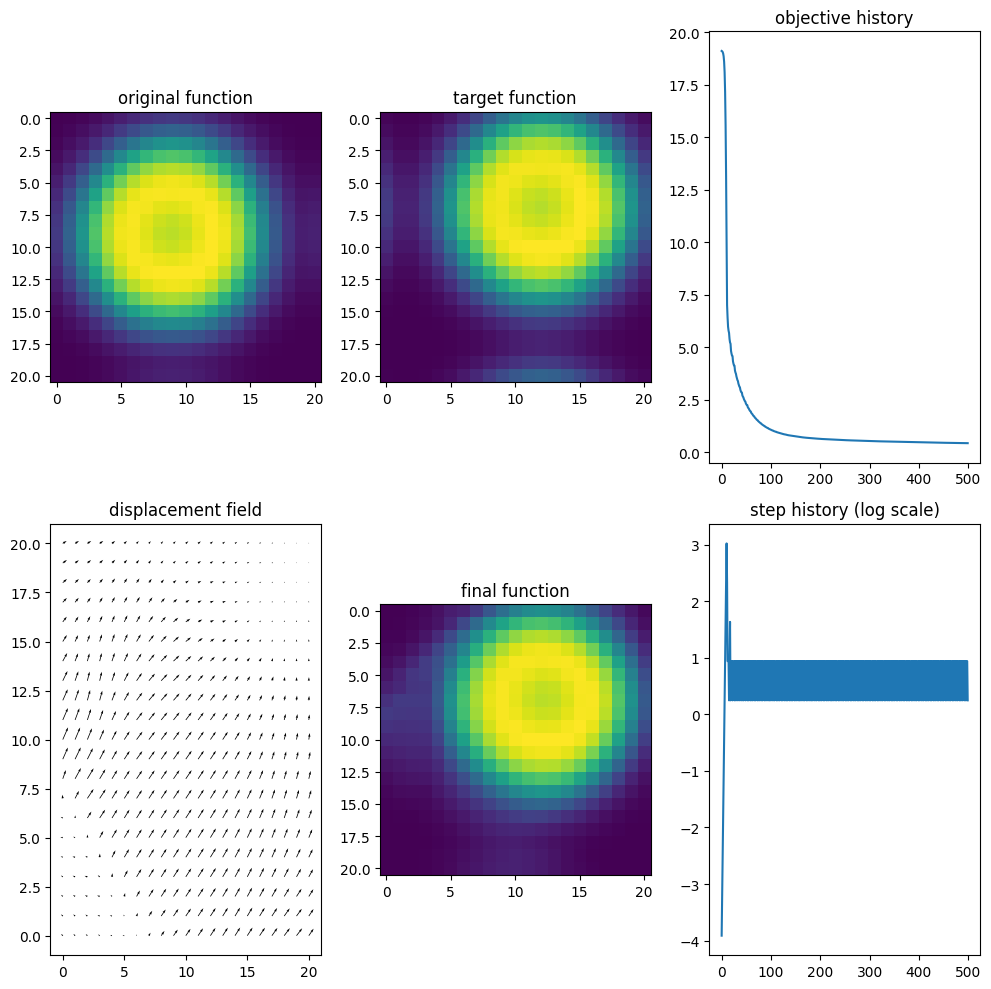

In [26]:
fig, ax = plt.subplots(2,3, figsize=(10,10))
ax[0,0].imshow(f)
ax[0,0].set_title('original function')
ax[0,1].imshow(g)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,-uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(f,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">
<li>Nous remarquons que nous obtenons bien notre target function. Il y a tout de même quelques différences, notamment sur le côté gauche.</li>
<li>Le displacement field montre le chemin parcouru. Les flèches sont cohérentes</li>
<li>Nous observons qu'avec peu de step on arrive à avoir à avoir une grande baisse de l'objective history. Mais pour avoir une valeur plus précise il nous faudrait plus d'itérations.</li>
<li>L'image est floutée pour la rendre différentiable.</li> 

# 4. Algorithme de moindres carrés.

On souhaite maintenant implémenter un algorithme de second ordre pour résoudre le problème $$(P)\quad\min_u E(u)+R(u)$$ afin d'accélérer la convergence de l'algorithme. Pour cela, on va reformuler le problème $(P)$ en un problème de moindres carrés et appliquer l'algorithme de Levenberg-Marquardt.

Soit:
$$\Psi(u)=\begin{pmatrix} 
f\circ(Id+u)-g \\ 
\sqrt{\mu}(\partial_xu_y+\partial_yu_x) \\ 
\sqrt{\mu+\lambda}(\partial_xu_x+\partial_yu_y) \end{pmatrix},$$
où $f\circ(id+u)$ est l'interpolation de $x\mapsto f(x+u(x))$ sur la grille. Minimiser $E(u)+R(u)$ est équivalent à résoudre le problème suivant:

>$$\min_u \|\Psi(u)\|_2^2.$$

Il s'agit maintenant d'un problème de moindres carrés que l'on va résoudre à l'aide de l'algorithme de Levenberg Marquardt :

$$
u_{k+1}=u_k- H_k^{-1} J_{\Psi}(u_k)^\top \Psi(u_k) \quad\mbox{ avec }\quad H_k=J_{\Psi}(u_k)^\top J_{\Psi}(u_k) +\varepsilon Id
$$

**Q6.** Calculer la matrice jacobienne de $\Psi$, notée $J_\Psi(u)$.
<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">
On cherche:
$$J_{\psi}(u)=\begin{pmatrix} 
\nabla \psi_1(u)^T \\ 
\nabla \psi_2(u)^T \\
\nabla \psi_3(u)^T \
 \end{pmatrix}$$

Cherchons $\nabla \psi_1(u)$ :
$$\begin{align}
J_{\psi_1}(u)&=J_f(Id+u) \times J_{Id+u}(u) \\
&=\nabla^Tf(Id+u) \times Id \\
&=\nabla^Tf(Id+u)
\end{align}$$
Et $\nabla \psi_1(u)=(J_{\psi_1}(u))^T $

Cherchons $\nabla \psi_2(u)$ :
$$\begin{align}
\nabla \psi_2(u)&=\sqrt{\mu} \nabla (\partial _x u_y + \partial _y u_x)\\
&=\sqrt{\mu} \begin{pmatrix} 
\partial _y  \\
\partial _x  \\
\end{pmatrix}
\end{align}$$

Cherchons $\nabla \psi_3(u)$ :
$$\begin{align}
\nabla \psi_3(u)&=\sqrt{\lambda +\mu} \nabla (\partial _x u_x + \partial _y u_y)\\
&=\sqrt{\lambda + \mu} \begin{pmatrix} 
\partial _x  \\
\partial _y  \\
\end{pmatrix}
\end{align}$$

Ainsi, on obtient:
$$\begin{align}
J_{\psi}(u) = \begin{pmatrix}
df_x(Id+u) & df_y(Id+u) \\
\sqrt{\mu}\partial _y   &\sqrt{\mu}\partial _x \\
\sqrt{\lambda + \mu}\partial _x & \sqrt{\lambda +\mu}\partial _y \\
\end{pmatrix}
\end{align}$$
</div>

**Q7.** Implémenter les fonctions `Psi`,`JPsi`, `JTPsi` et `JTJ` qui calculent respectivement:
- La valeur de $\Psi(u)$
- le produit de $J_\Psi(u)$ par une direction $v=(v_x,v_y)\in V^2$,

- le produit de $J_\Psi(u)^\top$ par $\phi=(\phi_1,\phi_2,\phi_3)\in V^3$,

- le produit de $(J_\Psi(u)^\top J_\Psi(u)+\epsilon I)$ par une direction $v=(v_x,v_y)\in V^2$.


Par convention `fu` représente $f\circ(Id+u)$ et `dfxu`et `dfyu` représentent les deux coordonnées de $(\nabla f)\circ(Id +u)$. On vous donne dans la cellulle suivante des tests de vérification.

In [28]:
def Psi(fu,g,ux,uy,lamb,mu) :
    Psi0 = fu - g
    Psi1 = np.sqrt(mu)*(dx(uy)+dy(ux))
    Psi2 = np.sqrt(mu+lamb)*(dx(ux)+dy(uy))
    return Psi0,Psi1,Psi2

def JPsi(vx,vy,dfxu,dfyu,lamb,mu) :
    JPsi0=dfxu*vx+dfyu*vy
    JPsi1=np.sqrt(mu)*dy(vx)+np.sqrt(mu)*dx(vy)
    JPsi2=np.sqrt(lamb+mu)*dx(vx)+np.sqrt(lamb+mu)*dy(vy)
    return JPsi0,JPsi1,JPsi2

def JTPsi(phi,dfxu,dfyu,lamb,mu) :
    ux=phi[0]*dfxu+np.sqrt(mu)*dyT(phi[1])+np.sqrt(lamb+mu)*dxT(phi[2])
    uy=phi[0]*dfyu+np.sqrt(mu)*dxT(phi[1])+np.sqrt(lamb+mu)*dyT(phi[2])
    return ux,uy
  
def JTJ(vx,vy,dfxu,dfyu,lamb,mu,epsilon) :
    uxs, uys = JTPsi(JPsi(vx,vy,dfxu,dfyu,lamb,mu),dfxu,dfyu,lamb,mu)
    uxs = uxs + epsilon*vx
    uys = uys + epsilon*vy
    return uxs,uys

In [29]:
n=50
np.random.seed(42)
fu=np.random.randn(n,n)
tmp_g=np.random.randn(n,n)
ux=np.random.randn(n,n)
uy=np.random.randn(n,n)
dfxu=np.random.randn(n,n)
dfyu=np.random.randn(n,n)
print('## TESTING PSI')
Psi0,Psi1,Psi2=Psi(fu,tmp_g,ux,uy,5,10)
print(Psi0.shape,Psi1.shape,Psi2.shape) #(50, 50) (50, 50) (50, 50)
print(np.linalg.norm(Psi0),np.linalg.norm(Psi1),np.linalg.norm(Psi2)) # 70.85046394690714 320.74675708932546 389.63146864883447
print('## TESTING JPSI')
Psi0,Psi1,Psi2=JPsi(ux,uy,dfxu,dfyu,5,10)
print(Psi0.shape,Psi1.shape,Psi2.shape) # (50, 50) (50, 50) (50, 50)
print(np.linalg.norm(Psi0),np.linalg.norm(Psi1),np.linalg.norm(Psi2)) #69.27576209907774 320.74675708932546 389.63146864883447
print('## TESTING JTPSI')
Psi0=np.random.randn(n,n)
Psi1=np.random.randn(n,n)
Psi2=np.random.randn(n,n)
vx,vy=JTPsi((Psi0,Psi1,Psi2),dfxu,dfyu,5,10)
print(vx.shape,vy.shape) # (50, 50) (50, 50)
print(np.linalg.norm(vx),np.linalg.norm(vy)) #355.08391793335545 352.46941362403214
print('## TESTING JTJ')
vx,vy=JTJ(ux,uy,dfxu,dfyu,5.,10.,1.)
print(vx.shape,vy.shape) # (50, 50) (50, 50)
print(np.linalg.norm(vx),np.linalg.norm(vy)) #3571.889912528785 3522.237528300008


## TESTING PSI
(50, 50) (50, 50) (50, 50)
70.85046394690714 320.74675708932546 389.63146864883436
## TESTING JPSI
(50, 50) (50, 50) (50, 50)
69.27576209907774 320.74675708932546 389.63146864883436
## TESTING JTPSI
(50, 50) (50, 50)
355.08391793335545 352.46941362403214
## TESTING JTJ
(50, 50) (50, 50)
3571.889912528785 3522.2375283000083


Calculons maintenant la direction de recherche $d_k$ comme solution du système linéaire:
$$(J_\Psi(u_k)^\top J_\Psi(u_k) +\epsilon I)\left(\begin{array}{c}
d_x\\
d_y
\end{array}\right) = -J_\Psi(u_k)^\top \Psi(u_k)$$
Pour cela, on vous donne l'algorithme suivant qui par la méthode du gradient conjugué calcule une solution $d=(d_x,d_y)\in V^2$ du problème:
$$(J_\Psi(u_k)^\top J_\Psi(u_k) +\epsilon I)\left(\begin{array}{c}
d_x\\
d_y
\end{array}\right) = b$$

In [30]:
 def CGSolve(u0x,u0y,lamb,mu,b,epsilon,dfxu,dfyu) :
    nitmax=100
    ux,uy=u0x,u0y #point de départ de l'algorithme
    # Computes JTJu
    Ax,Ay=JTJ(ux,uy,dfxu,dfyu,lamb,mu,epsilon)
    rx=b[0]-Ax
    ry=b[1]-Ay
    px,py=np.copy(rx),np.copy(ry)
    rsold=np.linalg.norm(rx)**2+np.linalg.norm(ry)**2
    for i in range(nitmax) :
        Apx,Apy=JTJ(px,py,dfxu,dfyu,lamb,mu,epsilon);
        alpha=rsold/(np.vdot(rx[:],Apx[:])+np.vdot(ry[:],Apy[:]))
        ux=ux+alpha*px
        uy=uy+alpha*py
        rx=rx-alpha*Apx
        ry=ry-alpha*Apy
        rsnew=np.linalg.norm(rx)**2+np.linalg.norm(ry)**2
        if np.sqrt(rsnew)<1e-10 :
            return [ux,uy]
        px=rx+rsnew/rsold*px
        py=ry+rsnew/rsold*py
        rsold=rsnew
    return ux,uy

**Q8.** Compléter l'algorithme RecalageGN implémentant la méthode de Levenberg-Marquardt.

In [31]:
def RecalageGN(f,g,lamb,mu,nitermax,stepini,epsi) : 
    ux=np.zeros(f.shape)
    uy=np.zeros(f.shape)  
    descentx=np.zeros(f.shape)
    descenty=np.zeros(f.shape) 
    # raise ValueError('Compute dfx and dfy here')
    dfx = dx(f)
    dfy = dy(f)
    CF=[]
    step_list=[]
    niter=0
    step=stepini
    while niter < nitermax and step > 1.e-8 : 
        niter+=1
        obj,fu=objective_function(f,g,ux,uy,lamb,mu)
        CF.append(obj)
        # raise ValueError('Compute dfxu,dfyu here')
        dfxu = interpol(dfx,ux,uy)
        dfyu = interpol(dfy,ux,uy)
        # raise ValueError('Compute b here')
        b=JTPsi(Psi(fu,g,ux,uy,mu,lamb),dfxu,dfyu,lamb,mu)
        [descentx,descenty]=CGSolve(descentx,descenty,lamb,mu,b,epsi,dfxu,dfyu)
        ux,uy,step=linesearch(ux,uy,step,descentx,descenty,obj,f,g,lamb,mu)
        step_list.append(step)
        # Display
        if (niter % 3 ==0) :
            print('iteration :',niter,' cost function :',obj,'step :',step, 'lambda :', lamb, 'mu :', mu)
    return ux,uy,np.array(CF),np.array(step_list), niter

**Q9.** Tester le nouvel algorithme et comparer sa vitesse de convergence avec celle de l'algorithme de gradient.

In [32]:
epsi=0.1
nitermax=1000
lamb=10
mu=20
start_time = time.time()
ux,uy,CF,step,niter=RecalageGN(f,g,lamb,mu,nitermax,step0,epsi)
print("Execution time: %s seconds" % (time.time() - start_time))
# On doit trouver comme première ligne
#iteration : 3  cost function : 18.9861786936971 step : 0.08

iteration : 3  cost function : 18.98617869369692 step : 0.08 lambda : 10 mu : 20
iteration : 6  cost function : 17.822725729073753 step : 0.64 lambda : 10 mu : 20
iteration : 9  cost function : 10.583907445957616 step : 5.12 lambda : 10 mu : 20
iteration : 12  cost function : 1.4813612203941995 step : 1.28 lambda : 10 mu : 20
iteration : 15  cost function : 0.8106833121779426 step : 1.28 lambda : 10 mu : 20
iteration : 18  cost function : 0.5186887353808454 step : 2.56 lambda : 10 mu : 20
iteration : 21  cost function : 0.38065345008343077 step : 2.56 lambda : 10 mu : 20
iteration : 24  cost function : 0.31475600884902993 step : 2.56 lambda : 10 mu : 20
iteration : 27  cost function : 0.28186752018946515 step : 2.56 lambda : 10 mu : 20
iteration : 30  cost function : 0.2656699500458225 step : 2.56 lambda : 10 mu : 20
iteration : 33  cost function : 0.25739516987549915 step : 2.56 lambda : 10 mu : 20
iteration : 36  cost function : 0.25333549704569375 step : 2.56 lambda : 10 mu : 20
ite

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">
On procède de la même manière que pour l'algorithme de gradient. Pour ce faire, on cherche les lamba et mu optimaux, qui minimisent la fonction coût ainsi que le nombre d'itérations total. <br> <br>

On choisit des valeurs de lambda et mu qui couvrent une plage raisonnable et qui peuvent être pertinents. Ensuite, on teste différentes combinaisons des paramètres. Finalement, on réduit de plus en plus la plage des valeurs pour lambda et mu afin d'augmenter la précision de nos résultats. <br> <br>

Dans l'exemple ci dessous, on suppose que lambda et mu prennent des valeurs comprises entre 0 et 0.1.
</div>

In [ ]:
# niter0_ex = np.zeros((5,5))
# lamb_ex = np.linspace(0,0.1,5)
# mu_ex = np.linspace(0,0.1,5)
# step0 = 0.01

# for i in range(5) :
#     for j in range(5) :
#         start_time = time.time()
#         ux,uy,CF,step,niter0_ex[i,j] = RecalageGN(f,g,lamb_ex[i],mu_ex[j],5000,step0, epsi)
#         print("Execution time: %s seconds" % (time.time() - start_time))
        

In [ ]:
# niter0_ex 

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">
Après plusieurs essais, on décide de choisir les valeurs suivantes : 
<li><b>lambda = 0.075</b></li>
<li><b>mu = 0.1 </b></li>
On voit dans la matrice ci-dessus que le nombre minimal d'itérations est de 21, toutefois celui ne garantit pas d'avoir une fonction coût minimale (3.44). Pour ce faire, on a choisi de trouver un équilibre entre les deux, et ainsi d'avoir un nombre d'itération de 135 avec une fonction coût ayant une valeur d'environ <b>0.26</b>. <br> <br>

De fait, on pouvait avoir un nombre d'itération plus petit, mais on aurait perdu en précision.
</div>

In [ ]:
epsi=0.1
nitermax=1000
lamb=0.075
mu=0.1 
start_time = time.time()
ux,uy,CF,step,niter=RecalageGN(f,g,lamb,mu,nitermax,step0,epsi)
print("Execution time: %s seconds" % (time.time() - start_time))
#iteration : 3  cost function : 18.9861786936971 step : 0.08

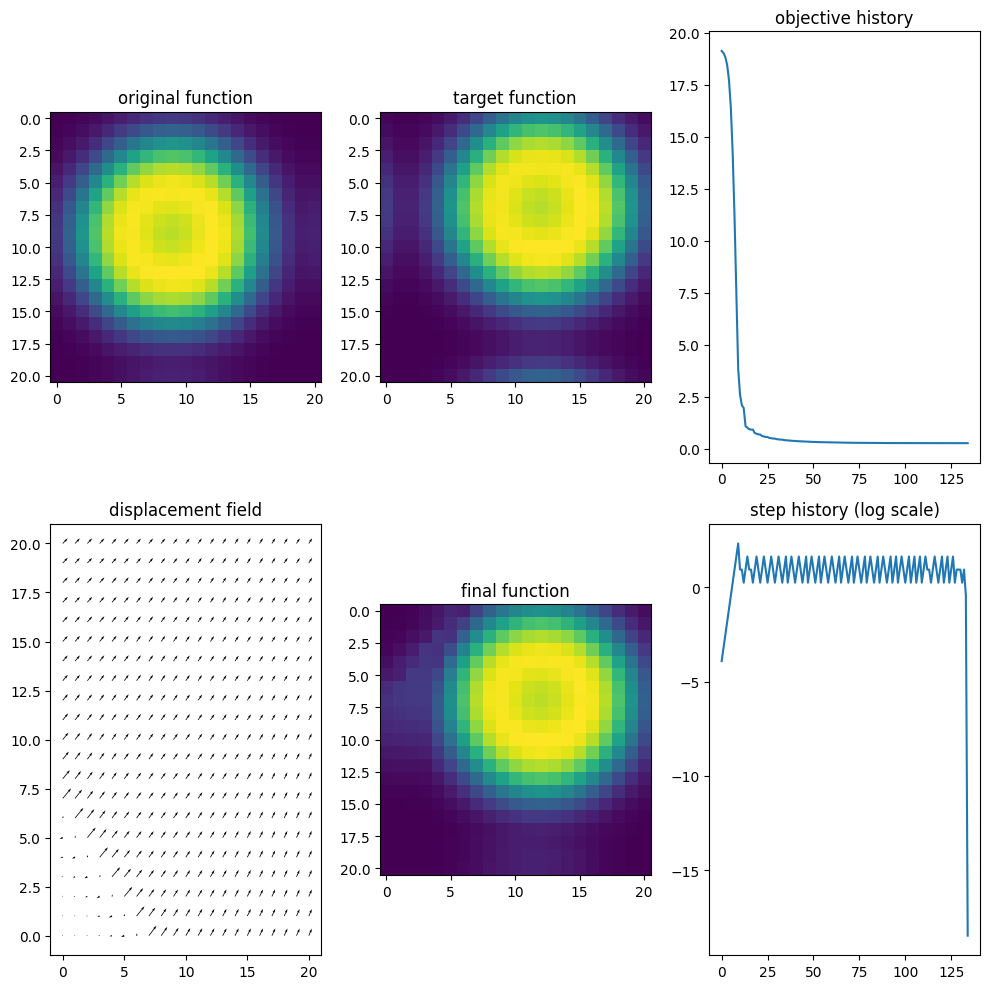

In [34]:
fig, ax = plt.subplots(2,3,figsize=(10,10))
ax[0,0].imshow(f)
ax[0,0].set_title('original function')
ax[0,1].imshow(g)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,-uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(f,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">
<li>On remarque qu'on obtient bien notre target function. Il y a tout de même quelques différences, notamment sur le côté bas.</li>
<li>On observe que l'algorithme de moindres carrés converge plus rapidement que l'algorithme de descente du gradient (135 itérations contre 519). Cet algorithme est beaucoup plus rapide que le précédent car nous faisons une descente de Newton qui est plus rapide qu'une descente de gradient.</li>
</div>

# 5. Jeu des différences
Maintenant que vous avez implémenté et testé les deux algorithmes sur l'image-jouet proposée, voyons que cela donne sur une image IRM d'un cerveau. Saurez-vous détecter les différences/déplacements entre les deux images ?

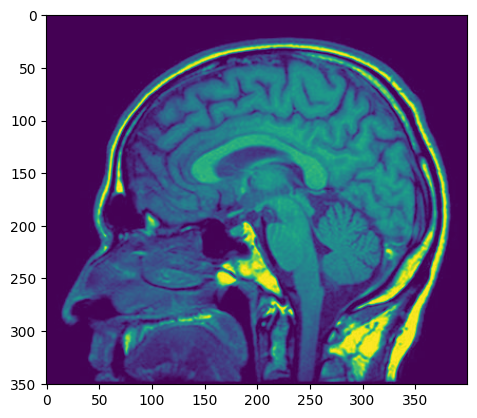

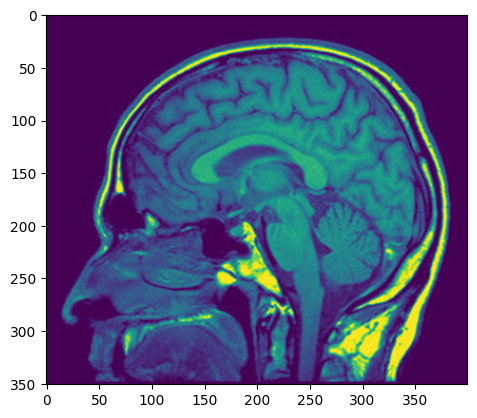

In [35]:
im1=Image.open('IRM1.png')
im2=Image.open("IRM2.png")
plt.imshow(plt.imread('IRM1.png'))
plt.show()
plt.imshow(plt.imread('IRM2.png'))
plt.show()

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">
On commence par flouter nos images pour les rendre différentiable comme précédemment. Or l'image est plus précise donc on va reduire le terme de floutage qui correspond au sigma ci dessous, pour éviter d'avoir une image trop floue.
</div>

In [36]:
[n,m]=im1.size
sigma=0.0001
[X,Y]=np.meshgrid(np.linspace(-1,1,n),np.linspace(-1,1,m), indexing='xy')
Z=np.sqrt(X*X+Y*Y)
G=np.fft.fftshift(np.exp(-(X**2+Y**2)/sigma**2))
f=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im1)))
g=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im2))) 
f=f/np.max(f)
g=g/np.max(g)

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">
Pour illustrer, nous voulions commencer par appliquer RecalageDG mais cette méthode est bien trop longue (beaucoup de temps d'éxécution et beaucoup d'itérations), donc pas optimale. Nous allons utiliser plutôt RecalageGN.
</div>

In [26]:
%%time
lamb=10
mu=20
nitermax=500
step0 = 0.01
ux,uy,CF,step, niter = RecalageDG(f,g,lamb,mu,nitermax,step0)

iteration : 3  cost function : 0.14381076908556115 step : 0.08 lambda : 10 mu : 20
iteration : 6  cost function : 0.1438096152752509 step : 0.01 lambda : 10 mu : 20
iteration : 9  cost function : 0.1438092281331238 step : 0.02 lambda : 10 mu : 20
iteration : 12  cost function : 0.14380902677406662 step : 0.04 lambda : 10 mu : 20
iteration : 15  cost function : 0.14380887503431738 step : 0.005 lambda : 10 mu : 20
iteration : 18  cost function : 0.14380883379757162 step : 0.005 lambda : 10 mu : 20
iteration : 21  cost function : 0.14380879419074236 step : 0.005 lambda : 10 mu : 20
iteration : 24  cost function : 0.14380875543386593 step : 0.005 lambda : 10 mu : 20
iteration : 27  cost function : 0.14380871725169816 step : 0.005 lambda : 10 mu : 20
iteration : 30  cost function : 0.14380867951277623 step : 0.005 lambda : 10 mu : 20
iteration : 33  cost function : 0.1438086421448682 step : 0.01 lambda : 10 mu : 20
iteration : 36  cost function : 0.14380861564441574 step : 0.005 lambda : 10

ValueError: operands could not be broadcast together with shapes (351,400) (21,21) 

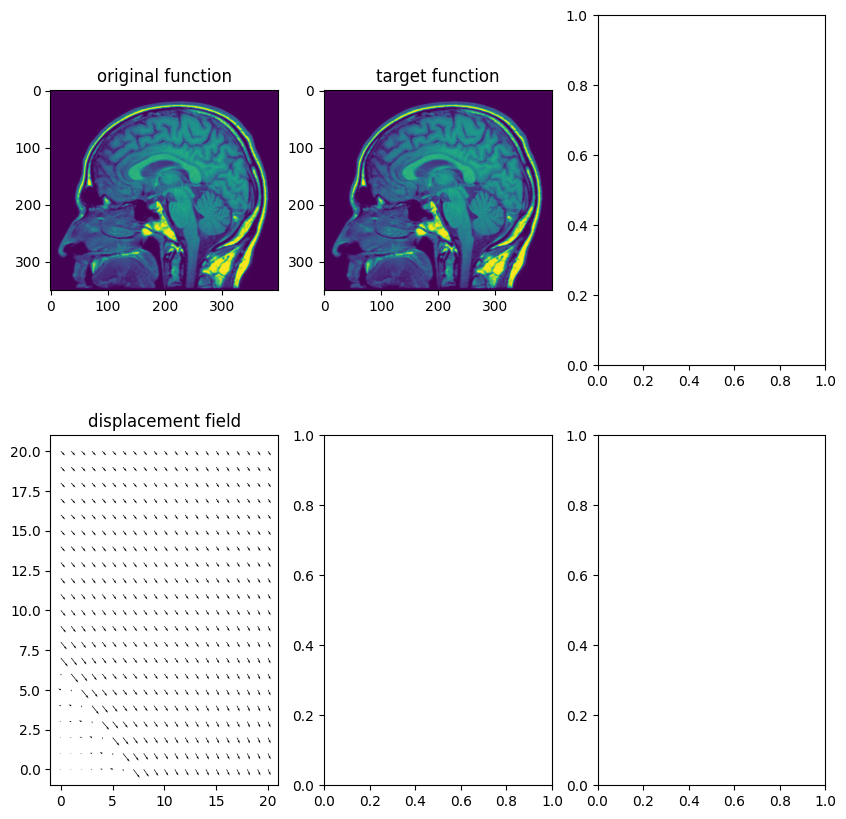

In [37]:
fig, ax = plt.subplots(2,3, figsize=(10,10))
ax[0,0].imshow(f)
ax[0,0].set_title('original function')
ax[0,1].imshow(g)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(f,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()

In [28]:
%%time
epsi=0.1
lamb = 10
mu = 20
nitermax=1000
ux,uy,CF,step=RecalageGN(f,g,lamb,mu,nitermax,step0,epsi)

iteration : 3  cost function : 0.14381006413170266 step : 0.08 lambda : 10 mu : 20
iteration : 6  cost function : 0.14380223044988968 step : 0.64 lambda : 10 mu : 20
iteration : 9  cost function : 0.14377088701701538 step : 5.12 lambda : 10 mu : 20
iteration : 12  cost function : 0.14371495650416666 step : 2.56 lambda : 10 mu : 20
iteration : 15  cost function : 0.14369509082974266 step : 2.56 lambda : 10 mu : 20
iteration : 18  cost function : 0.14368033700961919 step : 2.56 lambda : 10 mu : 20
iteration : 21  cost function : 0.14366108805976163 step : 2.56 lambda : 10 mu : 20
iteration : 24  cost function : 0.14364472715623564 step : 2.56 lambda : 10 mu : 20
iteration : 27  cost function : 0.14363409953136372 step : 1.28 lambda : 10 mu : 20
iteration : 30  cost function : 0.14361473802384683 step : 2.56 lambda : 10 mu : 20
iteration : 33  cost function : 0.14359840158425025 step : 2.56 lambda : 10 mu : 20
iteration : 36  cost function : 0.1435833980261023 step : 2.56 lambda : 10 mu :

ValueError: too many values to unpack (expected 4)

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">
On remarque que pour des valeurs de lambda et mu "importantes", l'algorithme GN prends beaucoup de temps à s'exécuter. On s'oriente donc vers de plus petites valeurs.
</div>

In [ ]:
# niter0_ex = np.zeros((5,5))
# lamb_ex = np.linspace(0,0.001,5)
# mu_ex = np.linspace(0,0.001,5)
# step0 = 0.01

# for i in range(5) :
#     for j in range(5) :
#         start_time = time.time()
#         ux,uy,CF,step,niter0_ex[i,j] = RecalageGN(f,g,lamb_ex[i],mu_ex[j],500,step0, epsi)
#         print("Execution time: %s seconds" % (time.time() - start_time))
        

In [ ]:
#niter0_ex

In [ ]:
# niter0_ex = np.zeros((5,5))
# lamb_ex = np.linspace(0,0.000001,5)
# mu_ex = np.linspace(0.,0.001,5)
# step0 = 0.01

# for i in range(5) :
#     for j in range(5) :
#         start_time = time.time()
#         ux,uy,CF,step,niter0_ex[i,j] = RecalageGN(f,g,lamb_ex[i],mu_ex[j],500,step0, epsi)
#         print("Execution time: %s seconds" % (time.time() - start_time))
        

In [ ]:
# niter0_ex

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">
Au final, on choisit lamba = 10*-9 et mu=0.00025.
</div>

In [38]:
%%time
epsi=0.1
lamb = 1e-9
mu = 0.00025
nitermax=500
ux,uy,CF,step, niter=RecalageGN(f,g,lamb,mu,nitermax,step0,epsi)

iteration : 3  cost function : 4.887395577918491 step : 0.08 lambda : 1e-09 mu : 0.00025
iteration : 6  cost function : 4.510840266010096 step : 0.64 lambda : 1e-09 mu : 0.00025
iteration : 9  cost function : 2.606099249403852 step : 5.12 lambda : 1e-09 mu : 0.00025
iteration : 12  cost function : 0.8606864566313295 step : 5.12 lambda : 1e-09 mu : 0.00025
iteration : 15  cost function : 0.657925319677513 step : 5.12 lambda : 1e-09 mu : 0.00025
iteration : 18  cost function : 0.597095487521537 step : 5.12 lambda : 1e-09 mu : 0.00025
iteration : 21  cost function : 0.5544889396140951 step : 2.56 lambda : 1e-09 mu : 0.00025
iteration : 24  cost function : 0.5237632005004685 step : 2.56 lambda : 1e-09 mu : 0.00025
iteration : 27  cost function : 0.5037739737772908 step : 2.56 lambda : 1e-09 mu : 0.00025
iteration : 30  cost function : 0.4768266920985222 step : 2.56 lambda : 1e-09 mu : 0.00025
iteration : 33  cost function : 0.46305309754594026 step : 2.56 lambda : 1e-09 mu : 0.00025
iterat

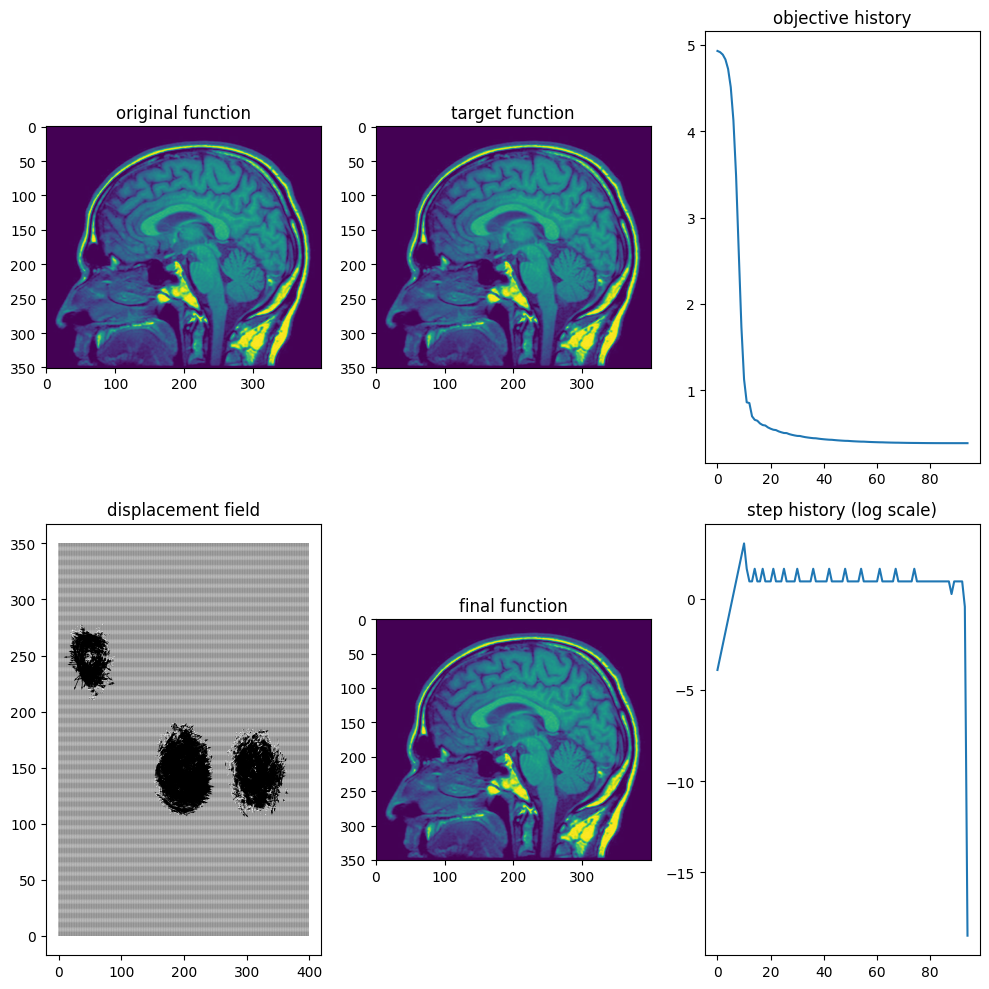

In [43]:
fig, ax = plt.subplots(2,3, figsize=(10,10))
ax[0,0].imshow(f)
ax[0,0].set_title('original function')
ax[0,1].imshow(g)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,-uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(f,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">
    <li> Nous obtenons un displacement flied différent sous forme de tâche. C'est toujours des flèches mais comme l'image est plus précise les flèches le sont aussi.</li>
    <li> Notre objective history n'est pas complétement à zero. Il n'a donc pas vraiment fini de converger.</li>
    <li> D'après les résultats, il y aura 3 "tumeurs". On observe que le displacement field est aux alentours des yeux. Et du milieu crâne.
</li>
    Par curiosité, nous avons chercher les différences plus précisement. Elles se situent aux alentours de : 
    <li>Tron du corps calleux</li>
    <li>Commissure antérieure</li>
    <li>Splénium du corps calleux</li>
</div>